#### Supplement Figure 6

##### Package imports, figure settings, color definitions
<img src="color_pal.png" width="500">

/Users/mlanghinrichs/Documents/Studium/MSc/09_hiwi_hoefer/01_project/memo_py/memo_py/selection.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


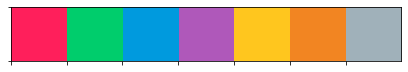

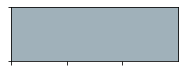

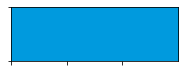

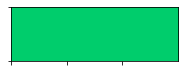

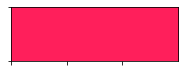

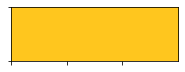

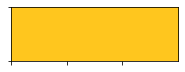

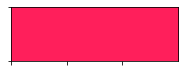

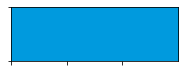

In [1]:
%matplotlib inline
%run settings_load.py

##### waiting time inference

In [2]:
evidsA = pickle.load(open('topology_files/estimation_data_pathway_topology_n1000_t11_2_toptrue3125_evids.pickle', 'rb'))
evidsB1 = pickle.load(open('topology_files/estimation_data_pathway_topology_n1000_t11_2_topB3125_part1_evids.pickle', 'rb'))
evidsB2 = pickle.load(open('topology_files/estimation_data_pathway_topology_n1000_t11_2_topB3125_part2_evids.pickle', 'rb'))
evidsB3 = pickle.load(open('topology_files/estimation_data_pathway_topology_n1000_t11_2_topB3125_part3_evids.pickle', 'rb'))
evidsC1 = pickle.load(open('topology_files/estimation_data_pathway_topology_n1000_t11_2_topC3125_part1_evids.pickle', 'rb')) 
evidsC2 = pickle.load(open('topology_files/estimation_data_pathway_topology_n1000_t11_2_topC3125_part2_evids.pickle', 'rb'))

evidsB = evidsB1 + evidsB2 + evidsB3
evidsC = evidsC1 + evidsC2
print(len(evidsA), len(evidsB), len(evidsC))

logevidsall = np.array([e[1] for e in evidsA+evidsB+evidsC])
print(len(logevidsall))
namesall = np.array(['A' + e[0][3:] for e in evidsA] + ['B' + e[0][3:] for e in evidsB] + ['C' + e[0][3:] for e in evidsC])

3125 3125 3125
9375


In [3]:
model_probs = me.selection.compute_model_probabilities_from_log_evidences(logevidsall)
print(namesall[list(model_probs).index(max(model_probs))])
sort_inds = np.array(- model_probs).argsort()
namesall_sorted = np.array(namesall)[sort_inds]
model_probs_sorted = np.array(model_probs)[sort_inds]

A42513


In [4]:
# are the best 100 networks enough to look at?
print(sum(model_probs_sorted[:100])) # 0.9999999999999934 => yes
all(['A' in name for name in namesall_sorted[:100]]) # => they are all A networks

0.9999999999999934


True

In [5]:
# from cell before, total inference = inference over A
# load A results
res = pickle.load(open('topology_files/estimation_data_pathway_topology_n1000_t11_2_toptrue3125.pickle', 'rb'))

In [6]:
res[0].net.net_modules

[{'module': 'module_0',
  'start-end': ('X_t', 'Y_t'),
  'start-end_ident': ('Z_0', 'Z_1'),
  'sym_rate': 'dxy',
  'sym_rate_ident': 'theta_0',
  'type': 'S -> E',
  'module_steps': 1},
 {'module': 'module_1',
  'start-end': ('Y_t', 'Z_t'),
  'start-end_ident': ('Z_1', 'Z_2'),
  'sym_rate': 'dyz',
  'sym_rate_ident': 'theta_1',
  'type': 'S -> E',
  'module_steps': 1},
 {'module': 'module_2',
  'start-end': ('X_t', 'X_t'),
  'start-end_ident': ('Z_0', 'Z_0'),
  'sym_rate': 'lx',
  'sym_rate_ident': 'theta_2',
  'type': 'S -> S + S',
  'module_steps': 1},
 {'module': 'module_3',
  'start-end': ('Y_t', 'Y_t'),
  'start-end_ident': ('Z_1', 'Z_1'),
  'sym_rate': 'ly',
  'sym_rate_ident': 'theta_3',
  'type': 'S -> S + S',
  'module_steps': 1},
 {'module': 'module_4',
  'start-end': ('Z_t', 'Z_t'),
  'start-end_ident': ('Z_2', 'Z_2'),
  'sym_rate': 'lz',
  'sym_rate_ident': 'theta_4',
  'type': 'S -> S + S',
  'module_steps': 1}]

In [17]:
# adapted from division waiting time function from settings_load.py script
# ADAPTED: additional input argument for the reaction/module index
# we only have topology A here, module index overview
# 0: dxy     1: dyz     2: lx     3: ly     4: lz

def waiting_time_distr_samples_topology(x, res, samples, time_max, mprior, module_ind):
    model_probs = me.selection.compute_model_probabilities(res, mprior=mprior)

    # set general x values
    y = np.zeros((x.shape[0], samples))

    # for checking set a counter
    model_type_counts = np.zeros((4,))

    for i in range(samples):
        # get random model according to p(M|D)
        model_rand = np.random.choice(range(len(model_probs)), p=model_probs, replace=True)
        est = res[model_rand]
        
        # ADAPTED: we only have markov/erlang type waiting times
        if 'net' in est.net.net_name:
            model_type_counts[0] += 1
            # get random theta according to p(theta|M, D)
            inds = np.array(range(0, est.bay_est_samples_weighted.shape[0]))
            theta_ind = np.random.choice(inds, replace=True)
            theta = est.bay_est_samples_weighted[theta_ind, :]

            # compute Gamma parameters
            theta_shape = est.net.net_modules[module_ind]['module_steps']
            theta_scale = 1.0/(theta[module_ind]*theta_shape)

            gamma = stats.gamma.pdf(x, a=theta_shape, scale=theta_scale)
        y[:, i] = gamma

    print(model_type_counts)
    return y

samples = 40000
time_max = 15.0 
x = np.linspace(0.0, time_max, num=200)
mprior = np.ones((len(res)))/len(res)
module_ind = 0

y = waiting_time_distr_samples_topology(x, res, samples, time_max, mprior, module_ind)

[40000.     0.     0.     0.]


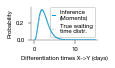

In [18]:
y_997_lower = np.percentile(y, 0.15, axis=1)
y_95_lower = np.percentile(y, 2.5, axis=1)
y_68_lower = np.percentile(y, 16.0, axis=1)
y_median = np.percentile(y, 50.0, axis=1)
y_68_upper = np.percentile(y, 84.0, axis=1)
y_95_upper = np.percentile(y, 97.5, axis=1)
y_997_upper = np.percentile(y, 99.85, axis=1)

# figure size adapted to fit activation times scale
plt.rcParams.update({'figure.figsize': (1.2, 0.6)}) # 1.4, 0.97
plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
    
plt.fill_between(x, y_997_lower, y_95_lower, color=cnaive, alpha=0.2, linewidth=0.0, zorder=100) # cnaive or cactiv
plt.fill_between(x, y_95_lower, y_68_lower, color=cnaive, alpha=0.4, linewidth=0.0, zorder=100) # cnaive or cactiv
plt.fill_between(x, y_68_lower, y_median, color=cnaive, alpha=0.6, linewidth=0.0, zorder=100) # cnaive or cactiv

plt.fill_between(x, y_median, y_68_upper, color=cnaive, alpha=0.6, linewidth=0.0, zorder=100) # cnaive or cactiv
plt.fill_between(x, y_68_upper, y_95_upper, color=cnaive, alpha=0.4, linewidth=0.0, zorder=100) # cnaive or cactiv
plt.fill_between(x, y_95_upper, y_997_upper, color=cnaive, alpha=0.2, linewidth=0.0, zorder=100) # cnaive or cactiv

# plt.plot(x, y_hdi_997_lower, color='darkorange', lw=0.5, alpha=0.2)
# plt.plot(x, y_hdi_95_lower, color='darkorange', lw=0.5, alpha=0.4)
# plt.plot(x, y_hdi_68_lower, color='blue', lw=0.5, alpha=0.6)
plt.plot(x, y_median, color=cnaive, lw=1, zorder=200, label='Inference \n(Moments)') # cnaive or cactiv
# plt.plot(x, y_hdi_68_upper, color='darkorange', lw=0.5, alpha=0.6)
# plt.plot(x, y_hdi_95_upper, color='darkorange', lw=0.5, alpha=0.4)
# plt.plot(x, y_hdi_997_upper, color='darkorange', lw=0.5, alpha=0.2)

# plot true waiting time distribution
gamma_true = stats.gamma.pdf(x, a=4, scale=1.0/(4*0.4)) # ENTER VALUES HERE FROM TRUE MODEL
plt.plot(x, gamma_true,lw=1, zorder=300, linestyle=':', color=grey, label='True waiting\ntime distr.')

plt.ylim(0.0, None)

plt.legend()
plt.ylabel('Probability')
plt.xlabel('Differentiation times X->Y (days)') # Differentiation / Division
plt.savefig('paper_figures/topology_waiting_times_dxy.pdf', bbox_inches='tight') # pdf, png

##### parameter marginals of best/true model from fit

In [38]:
sort_inds[0] # => 2102
est = res[2102]
print(est.net.net_name)

net42513


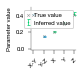

In [98]:
# # repair memocell versions
# est.bay_est_params_cred = est.bay_est_params_conf
# me.plots.est_parameter_plot(est, y_lim=(-0.05, 0.5)) # , save='paper_figures/topology_post_params_truemodel_net42513.pdf'

plt.rcParams.update({'figure.figsize': (0.8, 0.8)}) # 1.4, 0.97
plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# differentiation reactions
plt.errorbar([0,1], [p[0] for p in est.bay_est_params_conf[:2]], fmt='o',
                yerr=np.array([[p[0]-p[1],p[2]-p[0]] for p in est.bay_est_params_conf[:2]]).T,
                capsize=1.5, elinewidth=0.7, markeredgewidth=0.7,
                markersize=0.7, markeredgecolor=cnaive, color=cnaive)

# divisions reactions
plt.errorbar([2,3,4], [p[0] for p in est.bay_est_params_conf[2:5]], fmt='o',
                yerr=np.array([[p[0]-p[1],p[2]-p[0]] for p in est.bay_est_params_conf[2:5]]).T,
                capsize=1.5, elinewidth=0.7, markeredgewidth=0.7,
                markersize=0.7, markeredgecolor=cactiv, color=cactiv,
                label='Inferred value')
# errorbar plot test:
# plt.scatter([4, 4], [est.bay_est_params_conf[4][1], est.bay_est_params_conf[4][2]], s=0.2, c='red')

# plot true values
plt.scatter([0,1,2,3,4], [0.4, 0.15, 0.2, 0.3, 0.4], marker='x', color='grey', 
            s=8.0, linewidth=0.5, alpha=0.75, zorder=100, label='True value')

plt.xticks([0,1,2,3,4], ['X-Y', 'Y-Z', 'X', 'Y', 'Z'], rotation=45)
plt.ylim((-0.02, 0.5))
plt.legend()
plt.ylabel('Parameter value')
plt.savefig('paper_figures/topology_post_params_truemodel_net42513.pdf', bbox_inches='tight') # pdf, png

In [65]:
np.array([[p[0]-p[1],p[2]-p[0]] for p in est.bay_est_params_conf]).T

array([[0.00747089, 0.00576042, 0.00530048, 0.00956397, 0.01976779],
       [0.00763704, 0.00574706, 0.00544997, 0.00961905, 0.01879347]])

##### mean-only fits: topology A (true) results

In [34]:
res_evids = pickle.load(open('topology_files/estimation_data_pathway_topology_n1000_t11_2_toptrue3125_meanfit_evids.pickle', 'rb'))
print(len(res_evids))

3125


In [35]:
net_names = [e[0] for e in res_evids]
log_evids = np.array([e[1] for e in res_evids])
model_probs = me.selection.compute_model_probabilities_from_log_evidences(log_evids)
print(net_names[list(model_probs).index(max(model_probs))])
sort_inds = np.array(- model_probs).argsort()
net_names_sorted = np.array(net_names)[sort_inds]
model_probs_sorted = np.array(model_probs)[sort_inds]
log_evids_sorted = log_evids[sort_inds]

netA44525


In [36]:
print(model_probs_sorted[:10])
print(net_names_sorted[:10])
print(log_evids_sorted[:10])

[0.07847048 0.07106273 0.06899694 0.05947225 0.05830379 0.05389943
 0.05335568 0.05322835 0.04962098 0.04865048]
['netA44525' 'netA43511' 'netA44524' 'netA43512' 'netA44523' 'netA45525'
 'netA42514' 'netA43513' 'netA42513' 'netA43514']
[74.46924664 74.37008712 74.34058626 74.19203396 74.17219114 74.09364407
 74.08350461 74.0811152  74.01093785 73.99118587]


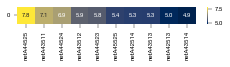

In [12]:
plt.figure(figsize=(4.0,0.3))
df = pd.DataFrame(np.array([model_probs_sorted[:10] * 100.0]), columns=net_names_sorted[:10]) # , index=rows
sns.heatmap(df, cmap='cividis', annot=True, fmt='.1f') # 'plasma' # annot=True
plt.yticks(rotation=0, va='center')
plt.xticks(rotation=90)
plt.savefig('paper_figures/topol_top_models_A_meanfit.pdf', bbox_inches='tight')

##### mean-only fits: topology B results
ADD HERE

##### mean-only fits: topology C results

In [31]:
res_evids = pickle.load(open('topology_files/estimation_data_pathway_topology_n1000_t11_2_topC3125_meanfit_evids.pickle', 'rb'))
print(len(res_evids))

3125


In [32]:
net_names = [e[0] for e in res_evids]
log_evids = np.array([e[1] for e in res_evids])
model_probs = me.selection.compute_model_probabilities_from_log_evidences(log_evids)
print(net_names[list(model_probs).index(max(model_probs))])
sort_inds = np.array(- model_probs).argsort()
net_names_sorted = np.array(net_names)[sort_inds]
model_probs_sorted = np.array(model_probs)[sort_inds]
log_evids_sorted = log_evids[sort_inds]

netC54511


In [33]:
print(model_probs_sorted[:10])
print(net_names_sorted[:10])
print(log_evids_sorted[:10])

[9.83378025e-01 6.86632817e-03 4.86641801e-03 2.80784344e-03
 7.71997028e-04 5.90112606e-04 3.95071327e-04 1.58622208e-04
 4.51142572e-05 4.20147028e-05]
['netC54511' 'netC54512' 'netC55511' 'netC53511' 'netC54513' 'netC44411'
 'netC54514' 'netC54515' 'netC54521' 'netC43411']
[17.02550204 12.06113792 11.71686658 11.16692516  9.87573385  9.60706653
  9.20581947  8.29327848  7.03595147  6.96477277]


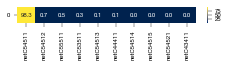

In [20]:
plt.figure(figsize=(4.0,0.3))
df = pd.DataFrame(np.array([model_probs_sorted[:10] * 100.0]), columns=net_names_sorted[:10]) # , index=rows
sns.heatmap(df, cmap='cividis', annot=True, fmt='.1f') # 'plasma' # annot=True
plt.yticks(rotation=0, va='center')
plt.xticks(rotation=90)
plt.savefig('paper_figures/topol_top_models_C_meanfit.pdf', bbox_inches='tight')

##### mean-only fits: summary
NOTE: still it seems, that A (true) topology can be identified from mean-only data which is maybe not expected; not clear if this data really contains this or we just underexplore the topology space for B and C topology as they touch bounds in the steps (as also for full data, but there the data should contain this info); so I wouldn't claim mean-only works that strongly (keep this data more as backup), it could however really be that it contains it given our synchronous initial conditions and dense time values (as this transition also seemed smooth for CD44 data and not binary in the sense that var/cov are needed, so just make it better if time points are too sparse and similar arguments)

In [23]:
evidsA = pickle.load(open('topology_files/estimation_data_pathway_topology_n1000_t11_2_toptrue3125_meanfit_evids.pickle', 'rb'))
# evidsB1 = pickle.load(open('topology_files/estimation_data_pathway_topology_n1000_t11_2_topB3125_part1_evids.pickle', 'rb'))
# evidsB2 = pickle.load(open('topology_files/estimation_data_pathway_topology_n1000_t11_2_topB3125_part2_evids.pickle', 'rb'))
# evidsB3 = pickle.load(open('topology_files/estimation_data_pathway_topology_n1000_t11_2_topB3125_part3_evids.pickle', 'rb'))
evidsC = pickle.load(open('topology_files/estimation_data_pathway_topology_n1000_t11_2_topC3125_meanfit_evids.pickle', 'rb')) 

# evidsB = evidsB1 + evidsB2 + evidsB3
print(len(evidsA), 
#       len(evidsB), 
      len(evidsC))

logevidsall = np.array([e[1] for e in evidsA+
#                         evidsB+
                        evidsC])
print(len(logevidsall))
namesall = np.array([e[0][3:] for e in evidsA] + 
#                     [e[0][3:] for e in evidsB] + 
                    [e[0][3:] for e in evidsC])

3125 3125
6250


In [25]:
model_probs = me.selection.compute_model_probabilities_from_log_evidences(logevidsall)
print(namesall[list(model_probs).index(max(model_probs))])
sort_inds = np.array(- model_probs).argsort()
namesall_sorted = np.array(namesall)[sort_inds]
model_probs_sorted = np.array(model_probs)[sort_inds]

A44525


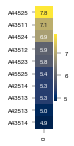

In [26]:
plt.figure(figsize=(0.4,2.25))
df = pd.DataFrame(np.array(model_probs_sorted[:10] * 100.0), index=namesall_sorted[:10]) # , index=rows
sns.heatmap(df, cmap='cividis', annot=True, fmt='.1f') # 'plasma' # annot=True
plt.yticks(rotation=0, va='center')
plt.xticks(rotation=90)
plt.savefig('paper_figures/topol_top_models_all_meanfit.pdf', bbox_inches='tight')

In [30]:
print(np.sum(model_probs[:3125]))
print(np.sum(model_probs[3125:6250]))

1.0000000000000042
9.005016536379891e-27


0.9999999999999934 0.0 9.646173351363013e-220


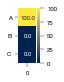

In [163]:
probssumA = np.sum(model_probs[:3125])
probssumB = np.sum(model_probs[3125:6250])
probssumC = np.sum(model_probs[6250:])
print(probssumA, probssumB, probssumC)

plt.figure(figsize=(0.4,1))
df = pd.DataFrame(np.array([probssumA, probssumB, probssumC]) * 100.0, index=['A', 'B', 'C']) # , index=rows
sns.heatmap(df, cmap='cividis', annot=True, fmt='.1f') # 'plasma' # annot=True
plt.yticks(rotation=0, va='center')
plt.savefig('paper_figures/topol_summary_probs_meanfit.pdf', bbox_inches='tight')
plt.show()

##### true model tests
- fit true model to own data (normal and meanfit)
- compare parameter posteriors (completely identifiable in both cases?)

In [14]:
data = pickle.load(open('topology_files/data_pathway_topology_n1000_t11_2.pickle', 'rb'))

In [15]:
data

In [16]:
topology = [
    {'start': 'X_t', 'end': 'Y_t', 'rate_symbol': 'dxy', 'type': 'S -> E', 'reaction_steps': 4},
    {'start': 'Y_t', 'end': 'Z_t', 'rate_symbol': 'dyz', 'type': 'S -> E', 'reaction_steps': 2},
    {'start': 'X_t', 'end': 'X_t', 'rate_symbol': 'lx', 'type': 'S -> S + S', 'reaction_steps': 5},
    {'start': 'Y_t', 'end': 'Y_t', 'rate_symbol': 'ly', 'type': 'S -> S + S', 'reaction_steps': 1},
    {'start': 'Z_t', 'end': 'Z_t', 'rate_symbol': 'lz', 'type': 'S -> S + S', 'reaction_steps': 3},
    ]

net = me.Network('net42513')
net.structure(topology)

nets = [net]
variables = [{'X_t': ('X_t', ), 'Y_t': ('Y_t', ), 'Z_t': ('Z_t', )}]*len(nets)
initial_values = [{'X_t': 1.0, 'Y_t': 0.0, 'Z_t': 0.0}]*len(nets)
theta_bounds = [{'dxy': (0.0, 1.0), 'dyz': (0.0, 1.0), 
                 'lx': (0.0, 1.0), 'ly': (0.0, 1.0), 'lz': (0.0, 1.0)}]*len(nets)
fit_mean_only = False # True or False

In [17]:
res = me.select_models(nets, variables, initial_values,
                    theta_bounds, data,
                    fit_mean_only=fit_mean_only,
                    nlive=1000, tolerance=0.01, parallel=False)

In [26]:
est = res[0]
est.bay_est_log_evidence

226.1541441603174

In [23]:
# compare to surround fit run
res_surround = pickle.load(open('topology_files/estimation_data_pathway_topology_n1000_t11_2_surround.pickle', 'rb'))
net_names = [est.net.net_name for est in res_surround]
model_probs = me.selection.compute_model_probabilities(res_surround)
print(net_names, model_probs)

['net42513', 'net32513', 'net52513', 'net41513', 'net43513', 'net42413', 'net42613', 'net42523', 'net42512', 'net42514', 'net34422', 'net35421', 'net44522'] [4.69241076e-01 1.17050761e-35 5.51607770e-27 7.95253734e-78
 1.41944097e-05 2.32393276e-20 1.79206217e-07 1.60729226e-63
 1.36491483e-01 3.94253067e-01 4.46286032e-19 9.93963416e-16
 1.49382334e-16]


In [28]:
res_surround[0].bay_est_log_evidence

225.61184594929145

In [29]:
me.selection.compute_model_probabilities_from_log_evidences(np.array([226.15, 225.61]))

array([0.63181242, 0.36818758])

226.1541441603174


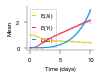

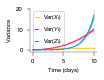

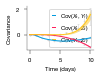

In [32]:
est = res[0]
print(est.bay_est_log_evidence)

# repair due to old memopy version
est.data.data_mean_exists_only = False

plt.rcParams.update({'figure.figsize': (1.2, 0.8)})

settings = {
    'X_t': {'label': 'E$(X_t)$', 'color': ctopx},
    'Y_t': {'label': 'E$(Y_t)$', 'color': ctopy},
    'Z_t': {'label': 'E$(Z_t)$', 'color': ctopz},
}
me.plots.est_bestfit_mean_plot(est, x_label='Time (days)', settings=settings)

settings = {
    ('X_t', 'X_t'): {'label': 'Var$(X_t)$', 'color': ctopx},
    ('Y_t', 'Y_t'): {'label': 'Var$(Y_t)$', 'color': ctopy},
    ('Z_t', 'Z_t'): {'label': 'Var$(Z_t)$', 'color': ctopz}
}
me.plots.est_bestfit_variance_plot(est, x_label='Time (days)', settings=settings)

settings = {
    ('X_t', 'Y_t'): {'label': 'Cov$(X_t, Y_t)$', 'color': ctopz},
    ('X_t', 'Z_t'): {'label': 'Cov$(X_t, Z_t)$', 'color': ctopy},
    ('Y_t', 'Z_t'): {'label': 'Cov$(Y_t, Z_t)$', 'color': ctopx}
}
me.plots.est_bestfit_covariance_plot(est, x_label='Time (days)', settings=settings)

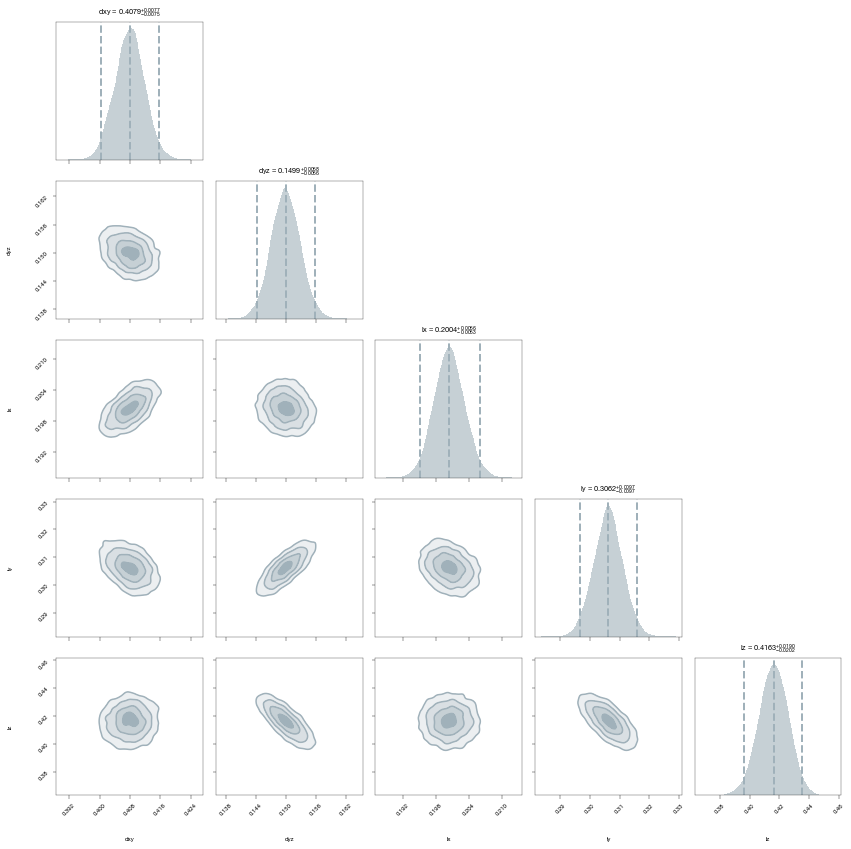

In [33]:
me.plots.est_corner_kernel_plot(est)

In [34]:
fit_mean_only = True
res_meanfit = me.select_models(nets, variables, initial_values,
                    theta_bounds, data,
                    fit_mean_only=fit_mean_only,
                    nlive=1000, tolerance=0.01, parallel=False)

In [36]:
est = res_meanfit[0]
est.bay_est_log_evidence

74.01711488422671

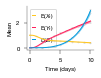

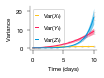

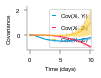

In [37]:
# repair due to old memopy version
est.data.data_mean_exists_only = False

plt.rcParams.update({'figure.figsize': (1.2, 0.8)})

settings = {
    'X_t': {'label': 'E$(X_t)$', 'color': ctopx},
    'Y_t': {'label': 'E$(Y_t)$', 'color': ctopy},
    'Z_t': {'label': 'E$(Z_t)$', 'color': ctopz},
}
me.plots.est_bestfit_mean_plot(est, x_label='Time (days)', settings=settings)

settings = {
    ('X_t', 'X_t'): {'label': 'Var$(X_t)$', 'color': ctopx},
    ('Y_t', 'Y_t'): {'label': 'Var$(Y_t)$', 'color': ctopy},
    ('Z_t', 'Z_t'): {'label': 'Var$(Z_t)$', 'color': ctopz}
}
me.plots.est_bestfit_variance_plot(est, x_label='Time (days)', settings=settings)

settings = {
    ('X_t', 'Y_t'): {'label': 'Cov$(X_t, Y_t)$', 'color': ctopz},
    ('X_t', 'Z_t'): {'label': 'Cov$(X_t, Z_t)$', 'color': ctopy},
    ('Y_t', 'Z_t'): {'label': 'Cov$(Y_t, Z_t)$', 'color': ctopx}
}
me.plots.est_bestfit_covariance_plot(est, x_label='Time (days)', settings=settings)

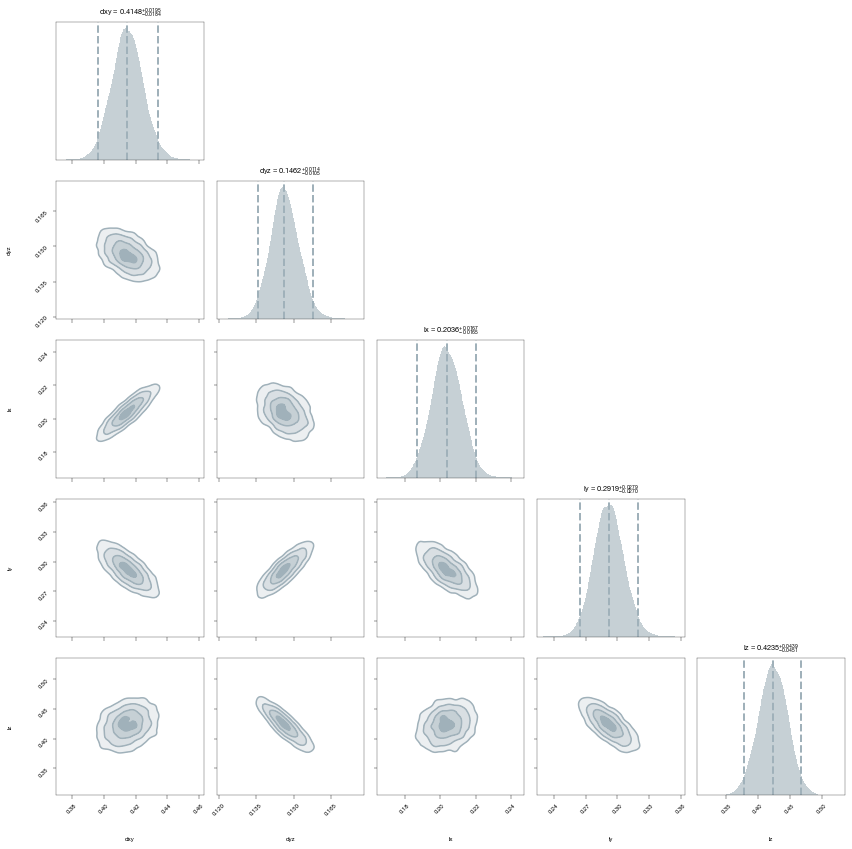

74.01711488422671


In [39]:
me.plots.est_corner_kernel_plot(est)
print(est.bay_est_log_evidence)

In [41]:
data.data_counts.shape

(1000, 3, 11)